Table of contents
1. [Precinct Shapefile](#shapefile)
2. [Election Results](#electionresults)
3. [Joining Election Results to Precinct Shapefile](#joining)
4. [Comparison to VEST](#comparison)

**Import Python Packages**

In [132]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopandas as gp
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

<a name="shapefile"></a>


# Precinct Shapefile

## Load VEST's Final File

In [133]:
vest_shp = gp.read_file("./raw-from-source/vest_az_2016/az_2016.shp")

In [134]:
vest_shp.shape

(1469, 13)

In [135]:
vest_shp.head(1)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry
0,AP0002,ALPINE,AP,216,60,13,2,4,196,65,22,5,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


<AxesSubplot:>

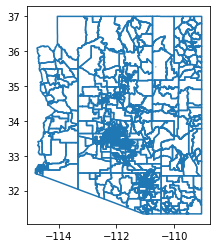

In [136]:
vest_shp.boundary.plot()

## Load Source Precinct File

VEST does not specify their source. This file is from Garrett Archer

In [137]:
precincts = gp.read_file("./raw-from-source/pct_2016/pct_2016.shp")

In [138]:
precincts.shape

(1469, 13)

In [139]:
precincts.head(1)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry
0,AP0002,ALPINE,AP,216,60,13,2,4,196,65,22,5,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


<AxesSubplot:>

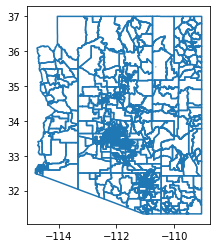

In [140]:
precincts.boundary.plot()

## Seeing if Source File is the same

Outer join the VEST's file and the raw precinct file on `pctnum`

In [141]:
vest_raw_joined = pd.merge(vest_shp,precincts,
                              left_on=['PCTNUM'],right_on=['PCTNUM'],
                              how='outer',indicator=True)

In [142]:
vest_raw_joined.groupby('_merge').count()

,PCTNUM,PRECINCTNA_x,CDE_COUNTY_x,G16PRERTRU_x,G16PREDCLI_x,G16PRELJOH_x,G16PREGSTE_x,G16PREOWRI_x,G16USSRMCC_x,G16USSDKIR_x,...,G16PRERTRU_y,G16PREDCLI_y,G16PRELJOH_y,G16PREGSTE_y,G16PREOWRI_y,G16USSRMCC_y,G16USSDKIR_y,G16USSGSWI_y,G16USSOWRI_y,geometry_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,...,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469


In [143]:
#Want to check this in the "both" match as well as the shapefile match
first_check = vest_raw_joined[(vest_raw_joined["_merge"]=="both")]

pdv_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_y')
vest_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_x')

pdv_shapes_elections_and_shapes.crs=vest_shapes_elections_and_shapes.crs

In [144]:
pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,
                                                   decimal=1).value_counts()

True    1469
dtype: int64

So the VEST shapefile is exactly the same as the one we received from Garrett Archer, including election results as well. We'll proceed assuming that this file is the raw source, since we do not have another option

# Election Results


## Reading in MEDSL Results

The SOS results are by county and would require quite a bit of processing to load all of them, so going to just try to use MEDSL results and see how close that gets. 

### Presidential Results

In [145]:
medsl_pres = pd.read_csv('./raw-from-source/medsl/2016-precinct-president/2016-precinct-president.csv', encoding='ISO-8859-1', low_memory = False) 

In [146]:
medsl_pres.head(5)

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
az_pres = medsl_pres[medsl_pres['state_fips'] == 4].copy()

In [148]:
az_pres.to_csv('./raw-from-source/medsl_az_pres_2016.csv')

To figure out the names of the offices that we need in MEDSL's file: 

In [149]:
az_pres.groupby(['office']).sum()

,year,special,state_fips,state_icpsr,county_fips,county_ansi,county_lat,county_long,writein,votes,...,candidate_last,candidate_first,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
office,,,,,,,,,,,,,,,,,,,,,
US President,34836480,0,69120,1054080,69374535.0,524831590.0,577668.090185,-1.930417e+06,3456,2604639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
az_pres[az_pres.office.isin(['US President'])].groupby(['office','party','candidate']).sum()['votes']

office        party        candidate      
US President  democratic   Hillary Clinton    1161165
              green        Jill Stein           34344
              libertarian  Gary Johnson        106326
              republican   Donald Trump       1252389
Name: votes, dtype: int64

In [151]:
az_pres.loc[(az_pres.candidate == '[Write-in]')]['votes'].sum()

50415

So the write-in in MEDSL includes write-in, McCullin, and Castle votes. See [wiki election results](https://en.wikipedia.org/wiki/2016_United_States_presidential_election_in_Arizona). 

The write-in candidates were listed as party nonpartisan in the MEDSL results

In [152]:
az_pres.loc[az_pres['candidate'] == "[Write-in]", 'party'] = 'write_in'

In [153]:
az_pres[az_pres.office.isin(['US President'])].groupby(['office','party','candidate']).sum()['votes']

office        party        candidate      
US President  democratic   Hillary Clinton    1161165
              green        Jill Stein           34344
              libertarian  Gary Johnson        106326
              republican   Donald Trump       1252389
              write_in     [Write-in]           50415
Name: votes, dtype: int64

### Senate Results

In [154]:
medsl_uss = pd.read_csv('./raw-from-source/medsl/2016-precinct-senate/2016-precinct-senate.csv', encoding='ISO-8859-1', low_memory = False) 

In [155]:
medsl_uss.head(5)

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,S6AL00302,"CRUMPTON, RONALD (RON) STEVEN",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,C.,Richard C. Shelby,NaN,NaN,S6AL00013,NaN,kg:/m/020yj1,300089.0,14659.0,608.0


In [156]:
az_uss = medsl_uss[medsl_uss['state_fips'] == 4].copy()

In [157]:
az_uss.to_csv('./raw-from-source/medsl_az_uss_2016.csv')

To figure out the names of the offices that we need in MEDSL's file: 

In [158]:
az_uss.groupby(['office']).sum()

,year,special,state_fips,state_icpsr,county_fips,county_ansi,county_lat,county_long,writein,votes,candidate_suffix,candidate_govtrack,candidate_icpsr,candidate_maplight
office,,,,,,,,,,,,,,
US Senate,27869184,0,55296,843264,55499628.0,419865272.0,462134.472148,-1.544334e+06,3456,2547042,0.0,1.037045e+09,51974784.0,2045952.0


In [159]:
az_uss[az_uss.office.isin(['US Senate'])].groupby(['office','party','candidate']).sum()['votes']

office     party       candidate      
US Senate  democratic  Ann Kirkpatrick    1031241
           green       Gary Swing          138631
           republican  John McCain        1359258
Name: votes, dtype: int64

In [160]:
az_uss.loc[(az_uss.candidate == '[Write-in]')]['votes'].sum()

17912

So it seems like maybe MEDSL has too many write-in votes for the senate election. [Ballotpedia](https://ballotpedia.org/United_States_Senate_election_in_Arizona,_2016) and [Wiki](https://en.wikipedia.org/wiki/2016_United_States_Senate_election_in_Arizona#General_election) both have it at 1,584 write-in votes. 

The write-in candidates were listed as party nonpartisan in the MEDSL results

In [161]:
az_uss.loc[az_uss['candidate'] == "[Write-in]", 'party'] = 'write_in'

In [162]:
az_uss[az_uss.office.isin(['US Senate'])].groupby(['office','party','candidate']).sum()['votes']

office     party       candidate      
US Senate  democratic  Ann Kirkpatrick    1031241
           green       Gary Swing          138631
           republican  John McCain        1359258
           write_in    [Write-in]           17912
Name: votes, dtype: int64

### Combine Presidential & Senate

In [163]:
az_pres.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [164]:
az_uss.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [165]:
az_elections = pd.concat([az_pres, az_uss])

In [166]:
az_elections.sample(5)

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
20705,2016,gen,False,Arizona,AZ,4,61,Maricopa County,4013.0,37026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35818,2016,gen,False,Arizona,AZ,4,61,Yavapai County,4025.0,42809.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
16636,2016,gen,False,Arizona,AZ,4,61,Cochise County,4003.0,25442.0,...,S.,John McCain,NaN,NaN,S6AZ00019; P80002801,NaN,kg:/m/0bymv,300071.0,15039.0,592.0
28232,2016,gen,False,Arizona,AZ,4,61,Maricopa County,4013.0,37026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23577,2016,gen,False,Arizona,AZ,4,61,Pima County,4019.0,25446.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pivoting MEDSL Election Results

Pivot the table by county and precinct

In [167]:
az_elections_pivot = az_elections.pivot_table(index = ['county_name','county_fips','precinct'],
                         columns = ['office','party'],
                        values = ['votes'],
                         aggfunc = 'sum')

Testing out dataset, investigating

In [168]:
az_elections_pivot.reset_index(inplace = True)

In [169]:
az_elections_pivot.columns = ['_'.join(filter(None, col)).replace(' ','_').replace('votes_','').lower() \
     for col in az_elections_pivot.columns]

In [170]:
az_elections_pivot.head(3)

,county_name,county_fips,precinct,us_president_democratic,us_president_green,us_president_libertarian,us_president_republican,us_president_write_in,us_senate_democratic,us_senate_green,us_senate_republican,us_senate_write_in
0,Apache County,4001.0,ALPINE|02,60,2,13,216,4,65,22,196,5
1,Apache County,4001.0,CANYON DE CHELLY|03,1387,32,72,143,51,1499,45,188,4
2,Apache County,4001.0,CHINLE|05,678,17,38,93,36,721,24,127,1


In [171]:
az_elections_pivot.columns

Index(['county_name', 'county_fips', 'precinct', 'us_president_democratic',
       'us_president_green', 'us_president_libertarian',
       'us_president_republican', 'us_president_write_in',
       'us_senate_democratic', 'us_senate_green', 'us_senate_republican',
       'us_senate_write_in'],
      dtype='object')

In [172]:
az_elections_pivot.columns = [col.replace('us_president',
             'pre').replace('us_senate',
             'uss').replace('democratic',
             'd').replace('republican',
             'r').replace('green',
             'g').replace('write_in',
             'w').replace('libertarian',
             'l') for col in az_elections_pivot.columns]

In [173]:
az_elections_pivot.head()

,county_name,county_fips,precinct,pre_d,pre_g,pre_l,pre_r,pre_w,uss_d,uss_g,uss_r,uss_w
0,Apache County,4001.0,ALPINE|02,60,2,13,216,4,65,22,196,5
1,Apache County,4001.0,CANYON DE CHELLY|03,1387,32,72,143,51,1499,45,188,4
2,Apache County,4001.0,CHINLE|05,678,17,38,93,36,721,24,127,1
3,Apache County,4001.0,CONCHO|09,228,11,44,1135,27,291,195,836,42
4,Apache County,4001.0,CORNFIELDS|10,349,3,16,33,12,375,5,37,1


In [174]:
az_elections_pivot.sum().astype(str)

county_name    Apache CountyApache CountyApache CountyApache ...
county_fips                                            5896966.0
precinct       ALPINE|02CANYON DE CHELLY|03CHINLE|05CONCHO|09...
pre_d                                                    1161165
pre_g                                                      34344
pre_l                                                     106326
pre_r                                                    1252389
pre_w                                                      50415
uss_d                                                    1031241
uss_g                                                     138631
uss_r                                                    1359258
uss_w                                                      17912
dtype: object

Re-order the MEDSL columns in the pivot table to match VEST's ordering

In [175]:
az_elections_pivot = az_elections_pivot[['county_name', 'county_fips','precinct', 
 'pre_r','pre_d','pre_l','pre_g','pre_w','uss_r', 'uss_d', 'uss_g', 'uss_w',]]

Compare the totals from the MEDSL results to VEST's:

In [176]:
vest_cols = [col for col in vest_shp.columns if 'G16' in col]
medsl_cols = [col for col in az_elections_pivot.columns if col != 'county_name' and col != 'county_fips' and col != 'precinct']

print('vest sum\t\t rdh sum\tnot equal')
print('-----------------------------------------------------')
for v, m in zip(vest_cols, medsl_cols):
    if vest_shp[v].sum() != int(az_elections_pivot[m].sum()):
        print(v, vest_shp[v].sum(), '\t', m, int(az_elections_pivot[m].sum()), '\tY')
    else:
        print(v, vest_shp[v].sum(), '\t', m, int(az_elections_pivot[m].sum()))

vest sum		 rdh sum	not equal
-----------------------------------------------------
G16PRERTRU 1252401 	 pre_r 1252389 	Y
G16PREDCLI 1161167 	 pre_d 1161165 	Y
G16PRELJOH 106327 	 pre_l 106326 	Y
G16PREGSTE 34345 	 pre_g 34344 	Y
G16PREOWRI 50417 	 pre_w 50415 	Y
G16USSRMCC 1359267 	 uss_r 1359258 	Y
G16USSDKIR 1031245 	 uss_d 1031241 	Y
G16USSGSWI 138634 	 uss_g 138631 	Y
G16USSOWRI 17914 	 uss_w 17912 	Y


So the MEDSL results are tiny bit off from VEST's that they cleaned from the SOS but almost identical. Interesting that VEST has the same write-in votes as MEDSL for the USS race, even though ballotpedia and wikipedia only has it at 1.5k

# Joining Election Results

## Join Attempt #1

In [177]:
az_elections_pivot.head(5)

,county_name,county_fips,precinct,pre_r,pre_d,pre_l,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w
0,Apache County,4001.0,ALPINE|02,216,60,13,2,4,196,65,22,5
1,Apache County,4001.0,CANYON DE CHELLY|03,143,1387,72,32,51,188,1499,45,4
2,Apache County,4001.0,CHINLE|05,93,678,38,17,36,127,721,24,1
3,Apache County,4001.0,CONCHO|09,1135,228,44,11,27,836,291,195,42
4,Apache County,4001.0,CORNFIELDS|10,33,349,16,3,12,37,375,5,1


In [178]:
az_elections_pivot.shape

(1469, 12)

In [179]:
precincts.head(5)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry
0,AP0002,ALPINE,AP,216,60,13,2,4,196,65,22,5,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,AP0003,CANYON DE CHELLY,AP,143,1387,72,32,51,188,1499,45,4,"POLYGON ((-109.71666 36.26151, -109.71658 36.2..."
2,AP0005,CHINLE,AP,93,678,38,17,36,127,721,24,1,"POLYGON ((-109.81183 36.27512, -109.80810 36.2..."
3,AP0009,CONCHO,AP,1135,228,44,11,27,836,291,195,42,"POLYGON ((-109.53982 34.44871, -109.53928 34.4..."
4,AP0011,COTTONWOOD,AP,47,589,26,11,21,84,632,10,1,"POLYGON ((-109.81768 36.14760, -109.81822 36.1..."


In [180]:
precincts.shape

(1469, 13)

Add the county name column to the precincts file for joining to.. 

In [181]:
counties = {'AP': 'Apache', 'GLA': 'Gila',
'LP': 'La Paz', 'NA': 'Navajo', 'SC': 'Santa Cruz', 'GI': 'Gila',
'CH': 'Cochise', 'GM': 'Graham', 'MC': 'Maricopa', 'PM': 'Pima', 'YA': 'Yavapai',
'CN': 'Coconino', 'GN': 'Greenlee', 'MO': 'Mohave', 'PN': 'Pinal', 'YU': 'Yuma'}

In [182]:
for v, k in counties.items(): 
    precincts.loc[precincts.CDE_COUNTY == v, 'county_name'] = k

In [183]:
precincts.head(5)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry,county_name
0,AP0002,ALPINE,AP,216,60,13,2,4,196,65,22,5,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache
1,AP0003,CANYON DE CHELLY,AP,143,1387,72,32,51,188,1499,45,4,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache
2,AP0005,CHINLE,AP,93,678,38,17,36,127,721,24,1,"POLYGON ((-109.81183 36.27512, -109.80810 36.2...",Apache
3,AP0009,CONCHO,AP,1135,228,44,11,27,836,291,195,42,"POLYGON ((-109.53982 34.44871, -109.53928 34.4...",Apache
4,AP0011,COTTONWOOD,AP,47,589,26,11,21,84,632,10,1,"POLYGON ((-109.81768 36.14760, -109.81822 36.1...",Apache


Split the precinct name from the precinct code by '|' in the MEDSL election results

In [184]:
az_elections_pivot[['precinct_name','precinct_code']] = az_elections_pivot['precinct'].str.split('|', expand = True)

In [185]:
az_elections_pivot.sample(20)

,county_name,county_fips,precinct,pre_r,pre_d,pre_l,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code
58,Cochise County,4003.0,Hereford|15,948,359,62,21,34,883,388,92,22,Hereford,15
314,Maricopa County,4013.0,0071 CALAVAR,564,455,51,14,19,587,390,87,5,0071 CALAVAR,None
205,Graham County,4009.0,Bylas #11,42,605,18,6,19,133,503,46,1,Bylas #11,None
972,Mohave County,4015.0,205-North Canyon,781,26,96,10,20,844,54,90,9,205-North Canyon,None
518,Maricopa County,4013.0,0275 HALL,878,1505,95,34,44,1146,1243,93,9,0275 HALL,None
550,Maricopa County,4013.0,0307 HOPEVILLE,1207,789,87,30,34,1214,742,124,20,0307 HOPEVILLE,None
1143,Pima County,4019.0,138,11,318,3,6,1,51,279,8,0,138,None
514,Maricopa County,4013.0,0271 GROVERS,1078,942,109,50,46,1093,811,207,22,0271 GROVERS,None
624,Maricopa County,4013.0,0381 MADRID,232,1087,45,22,20,393,903,69,3,0381 MADRID,None
1136,Pima County,4019.0,131,812,734,46,14,38,936,627,60,10,131,None


Looks like this is only needed for Apache County, so we'll deal with it later

Remove 'County' from county_name in election results

In [186]:
az_elections_pivot['county'] = az_elections_pivot['county_name'].str.replace(' County','')

In [187]:
az_elections_pivot.sample(5)

,county_name,county_fips,precinct,pre_r,pre_d,pre_l,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county
1133,Pima County,4019.0,128,753,850,74,31,40,866,772,69,7,128,None,Pima
341,Maricopa County,4013.0,0098 CHALLENGER,330,874,55,28,27,472,729,84,4,0098 CHALLENGER,None,Maricopa
62,Cochise County,4003.0,Palominas|19,650,241,56,18,18,574,297,74,14,Palominas,19,Cochise
1427,Yuma County,4027.0,11,963,467,95,33,31,969,415,106,20,11,None,Yuma
1415,Yavapai County,4025.0,236 - CAMP,319,113,9,1,5,292,112,19,2,236 - CAMP,None,Yavapai


In [188]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['county_name','PRECINCTNA'], right_on = ['county','precinct']
                            , indicator = True)

In [189]:
df_joined.groupby('_merge').count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_l,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,1351,1351,1351,1351,1351,1351,1351,1351,1351,1351,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,1351,1351,1351,1351,1351,1351,1351,1351,93,1351
both,118,118,118,118,118,118,118,118,118,118,...,118,118,118,118,118,118,118,118,0,118


## Fuzzy String Matching

Test out using a fuzzy string match, because it looks like precinct names are similar but have numbers or things added. 

In [190]:
# to install library in anaconda: conda install -c conda-forge fuzzywuzzy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def fuzzy_merge(df_1, df_2, key1, key2, threshold, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

In [191]:
precincts['county_precinct'] = precincts['county_name'] + ' ' + precincts['PRECINCTNA']
az_elections_pivot['county_precinct'] = az_elections_pivot['county'] + ' ' + az_elections_pivot['precinct']

In [192]:
fuzzy_merge(precincts, az_elections_pivot, 'county_precinct', 'county_precinct', threshold=90)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry,county_name,county_precinct,matches
0,AP0002,ALPINE,AP,216,60,13,2,4,196,65,22,5,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,Apache ALPINE,Apache ALPINE|02
1,AP0003,CANYON DE CHELLY,AP,143,1387,72,32,51,188,1499,45,4,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,Apache CANYON DE CHELLY,Apache CANYON DE CHELLY|03
2,AP0005,CHINLE,AP,93,678,38,17,36,127,721,24,1,"POLYGON ((-109.81183 36.27512, -109.80810 36.2...",Apache,Apache CHINLE,Apache CHINLE|05
3,AP0009,CONCHO,AP,1135,228,44,11,27,836,291,195,42,"POLYGON ((-109.53982 34.44871, -109.53928 34.4...",Apache,Apache CONCHO,Apache CONCHO|09
4,AP0011,COTTONWOOD,AP,47,589,26,11,21,84,632,10,1,"POLYGON ((-109.81768 36.14760, -109.81822 36.1...",Apache,Apache COTTONWOOD,Apache COTTONWOOD|11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,YU0014,Yuma 14,YU,186,142,15,13,3,206,100,27,3,"POLYGON ((-114.59885 32.68006, -114.59941 32.6...",Yuma,Yuma Yuma 14,Yuma 1
1465,YU0024,Yuma 24,YU,2517,855,105,21,36,2158,883,256,34,"POLYGON ((-114.36686 32.62695, -114.40973 32.6...",Yuma,Yuma Yuma 24,Yuma 2
1466,YU0016,Yuma 16,YU,624,488,57,13,17,658,401,63,10,"POLYGON ((-114.63288 32.63709, -114.63393 32.6...",Yuma,Yuma Yuma 16,Yuma 1
1467,LP0056,WENDEN,LP,85,23,4,0,4,74,25,13,0,"POLYGON ((-113.33383 33.90172, -113.33383 33.9...",La Paz,La Paz WENDEN,La Paz 056 WENDEN


Taking a look at the fuzzy results... actually looks pretty good

In [193]:
precincts.sample(5)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,G16USSGSWI,G16USSOWRI,geometry,county_name,county_precinct,matches
502,PM0071,PIMA 71,PM,9,114,4,1,1,22,100,4,0,"POLYGON ((-111.62313 31.50784, -111.62313 31.5...",Pima,Pima PIMA 71,
1105,MC0531,ROCKLEDGE,MC,1450,1518,147,22,68,1765,1268,86,17,"POLYGON ((-112.03620 33.31964, -112.03184 33.3...",Maricopa,Maricopa ROCKLEDGE,Maricopa 0531 ROCKLEDGE
740,MC0307,HOPEVILLE,MC,1207,789,87,30,34,1214,742,124,20,"POLYGON ((-112.59096 33.39204, -112.59096 33.3...",Maricopa,Maricopa HOPEVILLE,Maricopa 0307 HOPEVILLE
275,MC0591,SMP 2,MC,0,4,0,0,0,0,4,0,0,"POLYGON ((-112.02238 33.32332, -112.02232 33.3...",Maricopa,Maricopa SMP 2,Maricopa 0591 SMP 2
987,MC0183,DESERT VISTA,MC,722,689,67,18,26,853,566,62,15,"POLYGON ((-112.35800 33.48579, -112.35811 33.4...",Maricopa,Maricopa DESERT VISTA,Maricopa 0183 DESERT VISTA


## Join Attempt #2

Try to join again, using the fuzzy matches

In [194]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['county_name','matches'], right_on = ['county','county_precinct']
                            , indicator = True)

In [195]:
df_joined.groupby('_merge').count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,135,135,135,135,135,135,135,135,135,135,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,167,167,167,167,167,167,167,1,167,167
both,1334,1334,1334,1334,1334,1334,1334,1334,1334,1334,...,1334,1334,1334,1334,1334,1334,1334,92,1334,1334


See what did and different match

In [196]:
df_joined.columns

Index(['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI', 'geometry', 'county_name_x',
       'county_precinct_x', 'matches', 'county_name_y', 'county_fips',
       'precinct', 'pre_r', 'pre_d', 'pre_l', 'pre_g', 'pre_w', 'uss_r',
       'uss_d', 'uss_g', 'uss_w', 'precinct_name', 'precinct_code', 'county',
       'county_precinct_y', '_merge'],
      dtype='object')

In [197]:
df_joined.loc[df_joined['_merge'] == 'left_only'].groupby(['county_name_x']).count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
county_name_x,,,,,,,,,,,,,,,,,,,,,
Apache,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
Gila,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,2
Graham,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
La Paz,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,3
Maricopa,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
Pima,99,99,99,99,99,99,99,99,99,99,...,0,0,0,0,0,0,0,0,0,99
Yavapai,19,19,19,19,19,19,19,19,19,19,...,0,0,0,0,0,0,0,0,0,19
Yuma,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,0,0,0,0,0,9


In [198]:
df_joined.loc[df_joined['_merge'] == 'right_only'].groupby(['county']).count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county_precinct_y,_merge
county,,,,,,,,,,,,,,,,,,,,,
Apache,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Gila,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,0,2,2
Graham,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,0,5,5
La Paz,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,0,3,3
Maricopa,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,0,2,2
Pima,0,0,0,0,0,0,0,0,0,0,...,99,99,99,99,99,99,99,0,99,99
Yavapai,0,0,0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,19,0,19,19
Yuma,0,0,0,0,0,0,0,0,0,0,...,36,36,36,36,36,36,36,0,36,36


## County Specific Fixes

### Apache

In [199]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Apache') | (df_joined.county == 'Apache'))].sample(2)

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,184.0,556.0,51.0,3.0,PUERCO EAST & 49 PUERCO WES,48,Apache,Apache PUERCO EAST & 49 PUERCO WES|48,right_only
1468,AP0048,PUERCO E/W,AP,223.0,478.0,32.0,20.0,35.0,184.0,556.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [200]:
precincts.loc[(precincts.county_name == 'Apache') & (precincts.PRECINCTNA == 'PUERCO E/W'), 'matches'] = 'Apache PUERCO EAST & 49 PUERCO WES|48'

### Gila

In [201]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Gila') | (df_joined.county == 'Gila'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
111,GI0310,P/S EAST,GI,334.0,94.0,14.0,5.0,6.0,291.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
112,GI0315,P/S WEST,GI,932.0,323.0,47.0,13.0,17.0,830.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,291.0,98.0,32.0,7.0,Pine-Strawberry East,None,Gila,Gila Pine-Strawberry East,right_only
1471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,830.0,320.0,103.0,14.0,Pine-Strawberry West,None,Gila,Gila Pine-Strawberry West,right_only


In [202]:
precincts.loc[(precincts.county_name == 'Gila') & (precincts.PRECINCTNA == 'P/S WEST'), 'matches'] = 'Gila Pine-Strawberry West'
precincts.loc[(precincts.county_name == 'Gila') & (precincts.PRECINCTNA == 'P/S EAST'), 'matches'] = 'Gila Pine-Strawberry East'

### Graham

In [203]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Graham') | (df_joined.county == 'Graham'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
119,GM0010,FORT THOMAS,GM,159.0,22.0,5.0,2.0,1.0,131.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,131.0,26.0,24.0,3.0,Ft Thomas #10,None,Graham,Graham Ft Thomas #10,right_only
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,590.0,246.0,54.0,6.0,Layton #5,None,Graham,Graham Layton #5,right_only
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,558.0,303.0,51.0,11.0,Safford #2,None,Graham,Graham Safford #2,right_only
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,319.0,113.0,28.0,4.0,Safford #3,None,Graham,Graham Safford #3,right_only
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.0,837.0,247.0,78.0,8.0,Thatcher #7,None,Graham,Graham Thatcher #7,right_only


See if there are the same number of precincts in Graham in the election results and the shapefile

In [204]:
precincts[precincts.county_name == 'Graham'].shape

(22, 16)

In [205]:
az_elections_pivot[az_elections_pivot.county == 'Graham'].shape

(22, 16)

In [206]:
df_joined.loc[((df_joined.county_name_x == 'Graham') | (df_joined.county == 'Graham'))][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','precinct','county','pre_r']]

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,precinct,county,pre_r
114,GM0006,THATCHER,Graham,451.0,Thatcher #6,Graham,451.0
115,GM0007,THATCHER,Graham,847.0,Thatcher #6,Graham,451.0
118,GM0009,PIMA,Graham,1239.0,Pima #9,Graham,1239.0
119,GM0010,FORT THOMAS,Graham,159.0,NaN,NaN,NaN
120,GM0011,BYLAS,Graham,42.0,Bylas #11,Graham,42.0
121,GM0012,KLONDYKE,Graham,28.0,Klondyke #12,Graham,28.0
122,GM0013,BONITA,Graham,105.0,Bonita #13,Graham,105.0
124,GM0016,PERIDOT,Graham,40.0,Peridot #16,Graham,40.0
125,GM0017,CACTUS,Graham,109.0,Cactus #17,Graham,109.0
440,GM0001,SOLOMON,Graham,428.0,Solomon #1,Graham,428.0


Pulled the above to a sheet and lined them up, exported the following data dictionary:

In [207]:
graham_dict = {'GM0006':'Thatcher #6','GM0007':'Thatcher #7','GM0009':'Pima #9','GM0010':'Ft Thomas #10',
               'GM0011':'Bylas #11','GM0012':'Klondyke #12','GM0013':'Bonita #13','GM0016':'Peridot #16',
               'GM0017':'Cactus #17','GM0001':'Solomon #1','GM0002':'Safford #2','GM0003':'Safford #3',
               'GM0015':'Safford #15','GM0018':'Jackson #18','GM0004':'Layton #4','GM0005':'Layton #5',
               'GM0008':'Central #8','GM0014':'Thunderbird #14','GM0021':'Quatro Cerros #21',
               'GM0019':'Desert Hills #19','GM0022':'Gila River #22','GM0020':'Artesia #20'}

In [208]:
for key in graham_dict:
    precincts.loc[(precincts.county_name == 'Graham') & (precincts.PCTNUM == key), 'matches'] = 'Graham ' + graham_dict[key]

### La Paz

In [209]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'La Paz') | (df_joined.county == 'La Paz'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
557,LP0064,QUARTZSITE 3,LP,273.0,66.0,9.0,2.0,8.0,248.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
558,LP0051,PARKER 1,LP,951.0,702.0,85.0,43.0,35.0,996.0,660.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
559,LP0058,QUARTZSITE 2,LP,551.0,149.0,32.0,10.0,7.0,447.0,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,996.0,660.0,117.0,17.0,051 PARKER,None,La Paz,La Paz 051 PARKER,right_only
1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,447.0,196.0,71.0,15.0,058 QUARTZSITE TWO,None,La Paz,La Paz 058 QUARTZSITE TWO,right_only
1479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,248.0,78.0,22.0,3.0,064 QUARTZSITE THREE,None,La Paz,La Paz 064 QUARTZSITE THREE,right_only


In [210]:
precincts.loc[(precincts.county_name == 'La Paz') & (precincts.PRECINCTNA == 'PARKER 1'), 'matches'] = 'La Paz 051 PARKER'
precincts.loc[(precincts.county_name == 'La Paz') & (precincts.PRECINCTNA == 'QUARTZSITE 2'), 'matches'] = 'La Paz 058 QUARTZSITE TWO'
precincts.loc[(precincts.county_name == 'La Paz') & (precincts.PRECINCTNA == 'QUARTZSITE 3'), 'matches'] = 'La Paz 064 QUARTZSITE THREE'

### Maricopa

In [211]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Maricopa') | (df_joined.county == 'Maricopa'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
1209,MC0548,TOWNE MEADOWS,MC,1131.0,717.0,122.0,26.0,74.0,1300.0,601.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,1124.0,970.0,120.0,10.0,0389 MARICOPA,None,Maricopa,Maricopa 0389 MARICOPA,right_only
1481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.0,1300.0,601.0,101.0,14.0,0548 TOWN MEADOWS,None,Maricopa,Maricopa 0548 TOWN MEADOWS,right_only


In [212]:
df_joined.loc[((df_joined.county_name_x == 'Maricopa') | (df_joined.county == 'Maricopa')) & (df_joined.PCTNUM == 'MC0389')][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','precinct','county','pre_r']]

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,precinct,county,pre_r
1040,MC0389,MARICOPA,Maricopa,928.0,0001 ACACIA,Maricopa,1156.0


In [213]:
df_joined.loc[((df_joined.county_name_x == 'Maricopa') | (df_joined.county == 'Maricopa')) & (df_joined.PCTNUM == 'MC0001')][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','precinct','county','pre_r']]

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,precinct,county,pre_r
1039,MC0001,ACACIA,Maricopa,1156.0,0001 ACACIA,Maricopa,1156.0


In [214]:
precincts.loc[(precincts.county_name == 'Maricopa') & (precincts.PCTNUM == 'MC0548'), 'matches'] = 'Maricopa 0548 TOWN MEADOWS'
precincts.loc[(precincts.county_name == 'Maricopa') & (precincts.PCTNUM == 'MC0389'), 'matches'] = 'Maricopa 0389 MARICOPA'

### Pima

In [215]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Pima') | (df_joined.county == 'Pima'))]

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y,_merge
274,PM0004,PIMA 4,PM,59.0,597.0,17.0,23.0,8.0,158.0,506.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
275,PM0010,PIMA 10,PM,825.0,749.0,36.0,5.0,23.0,804.0,696.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
276,PM0012,PIMA 12,PM,1833.0,1688.0,115.0,28.0,57.0,1965.0,1538.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
277,PM0022,PIMA 22,PM,596.0,1591.0,66.0,30.0,28.0,758.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
278,PM0027,Pima 27,PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.0,632.0,351.0,58.0,6.0,095,None,Pima,Pima 095,right_only
1577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,614.0,1158.0,88.0,9.0,096,None,Pima,Pima 096,right_only
1578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,449.0,875.0,61.0,8.0,097,None,Pima,Pima 097,right_only
1579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0,620.0,1173.0,125.0,3.0,098,None,Pima,Pima 098,right_only


In [216]:
df_joined.loc[((df_joined.county_name_x == 'Pima') | (df_joined.county == 'Pima'))][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','matches','precinct','county','county_precinct_y','pre_r']]

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,matches,precinct,county,county_precinct_y,pre_r
274,PM0004,PIMA 4,Pima,59.0,,NaN,NaN,NaN,NaN
275,PM0010,PIMA 10,Pima,825.0,,NaN,NaN,NaN,NaN
276,PM0012,PIMA 12,Pima,1833.0,,NaN,NaN,NaN,NaN
277,PM0022,PIMA 22,Pima,596.0,,NaN,NaN,NaN,NaN
278,PM0027,Pima 27,Pima,0.0,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1576,NaN,NaN,NaN,NaN,NaN,095,Pima,Pima 095,569.0
1577,NaN,NaN,NaN,NaN,NaN,096,Pima,Pima 096,481.0
1578,NaN,NaN,NaN,NaN,NaN,097,Pima,Pima 097,329.0
1579,NaN,NaN,NaN,NaN,NaN,098,Pima,Pima 098,508.0


In [217]:
precincts[['part1_temp', 'part2_temp', 'part3_temp']] \
    = precincts['PRECINCTNA'].str.split(' ',2, expand = True)

In [218]:
precincts.loc[precincts.county_name == 'Pima'][['part1_temp', 'part2_temp', 'part3_temp']].head()

,part1_temp,part2_temp,part3_temp
273,PIMA,4,None
279,PIMA,10,None
280,PIMA,12,None
286,PIMA,22,None
291,Pima,27,None


In [219]:
precincts['matches'] = np.where(precincts['county_name'] == 'Pima', 
         precincts['county_name'] + ' ' + \
         precincts['part2_temp'].apply(lambda x: x.zfill(3) if x else x), 
         precincts['matches'])

In [220]:
precincts.loc[precincts.county_name == 'Pima'][['matches','part1_temp', 'part2_temp', 'part3_temp']].head()

,matches,part1_temp,part2_temp,part3_temp
273,Pima 004,PIMA,4,None
279,Pima 010,PIMA,10,None
280,Pima 012,PIMA,12,None
286,Pima 022,PIMA,22,None
291,Pima 027,Pima,27,None


### Yavapai

In [221]:
df_joined.loc[(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Yavapai') | (df_joined.county == 'Yavapai'))][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','matches','precinct','county','county_precinct_y','pre_r']]

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,matches,precinct,county,county_precinct_y,pre_r
510,YA0209,WICK,Yavapai,237.0,,NaN,NaN,NaN,NaN
511,YA0214,KIRK,Yavapai,344.0,,NaN,NaN,NaN,NaN
512,YA0217,WIND,Yavapai,57.0,,NaN,NaN,NaN,NaN
513,YA0218,WELL,Yavapai,1290.0,,NaN,NaN,NaN,NaN
514,YA0225,IRON,Yavapai,3420.0,,NaN,NaN,NaN,NaN
515,YA0240,CARS,Yavapai,466.0,,NaN,NaN,NaN,NaN
516,YA0203,FAIR,Yavapai,1992.0,,NaN,NaN,NaN,NaN
517,YA0204,GOLF,Yavapai,3022.0,,NaN,NaN,NaN,NaN
518,YA0219,FORT,Yavapai,3202.0,,NaN,NaN,NaN,NaN
519,YA0220,RIM,Yavapai,14.0,,NaN,NaN,NaN,NaN


In [222]:
yavapai_dict = {'YA0209':'Yavapai 209 - WICK',
'YA0214':'Yavapai 214 - KIRK',
'YA0217':'Yavapai 217 - WIND',
'YA0218':'Yavapai 218 - WELL',
'YA0225':'Yavapai 225 - IRON',
'YA0240':'Yavapai 240 - CARS',
'YA0203':'Yavapai 203 - FAIR',
'YA0204':'Yavapai 204 - GOLF',
'YA0219':'Yavapai 219 - FORT',
'YA0220':'Yavapai 220 - RIM',
'YA0221':'Yavapai 221 - SALT',
'YA0222':'Yavapai 222 - BUG',
'YA0229':'Yavapai 229 - ONYX',
'YA0205':'Yavapai 205 - MINE',
'YA0206':'Yavapai 206 - HILL',
'YA0208':'Yavapai 208 - YARN',
'YA0215':'Yavapai 215 - BUCK',
'YA0227':'Yavapai 227 - RUBY',
'YA0236':'Yavapai 236 - CAMP',}

In [223]:
for key in yavapai_dict:
    precincts.loc[(precincts.county_name == 'Yavapai') & (precincts.PCTNUM == key), 'matches'] = yavapai_dict[key]

### Yuma

In [224]:
df_joined.loc[ #(df_joined._merge != 'both') & \
              ((df_joined.county_name_x == 'Yuma') | (df_joined.county == 'Yuma'))][['PCTNUM',
                    'PRECINCTNA','county_name_x','G16PRERTRU','matches','precinct','county','county_precinct_y','pre_r']].sample(30)

,PCTNUM,PRECINCTNA,county_name_x,G16PRERTRU,matches,precinct,county,county_precinct_y,pre_r
1466,YU0033,Yuma 33,Yuma,227.0,Yuma 33,33,Yuma,Yuma 33,227.0
773,YU0034,Yuma 34,Yuma,340.0,Yuma 3,3,Yuma,Yuma 3,235.0
760,YU0013,Yuma 13,Yuma,373.0,Yuma 1,1,Yuma,Yuma 1,174.0
1630,NaN,NaN,NaN,NaN,NaN,43,Yuma,Yuma 43,14.0
1619,NaN,NaN,NaN,NaN,NaN,31,Yuma,Yuma 31,175.0
1607,NaN,NaN,NaN,NaN,NaN,18,Yuma,Yuma 18,128.0
1616,NaN,NaN,NaN,NaN,NaN,28,Yuma,Yuma 28,107.0
775,YU0035,Yuma 35,Yuma,658.0,Yuma 3,3,Yuma,Yuma 3,235.0
783,YU0007,Yuma 07,Yuma,199.0,,NaN,NaN,NaN,NaN
1615,NaN,NaN,NaN,NaN,NaN,27,Yuma,Yuma 27,285.0


In [225]:
precincts[['part1_temp', 'part2_temp', 'part3_temp']] \
    = precincts['PRECINCTNA'].str.split(' ',2, expand = True)

In [226]:
precincts.loc[precincts.county_name == 'Yuma'][['part1_temp', 'part2_temp', 'part3_temp']].head()

,part1_temp,part2_temp,part3_temp
656,Yuma,44,None
657,Yuma,21,None
658,Yuma,17,None
659,Yuma,20,None
660,Yuma,37,None


In [227]:
precincts['matches'] = np.where(precincts['county_name'] == 'Yuma', 
         precincts['county_name'] + ' ' + \
         precincts['part2_temp'].str.lstrip('0'), 
         precincts['matches'])

In [228]:
precincts.loc[precincts.county_name == 'Yuma'][['matches','part1_temp', 'part2_temp', 'part3_temp']].head()

,matches,part1_temp,part2_temp,part3_temp
656,Yuma 44,Yuma,44,None
657,Yuma 21,Yuma,21,None
658,Yuma 17,Yuma,17,None
659,Yuma 20,Yuma,20,None
660,Yuma 37,Yuma,37,None


## Join Attempt #3

In [229]:
df_joined = precincts.merge(az_elections_pivot, how = 'outer'
                            , left_on = ['county_name','matches'], right_on = ['county','county_precinct']
                            , indicator = True)

In [230]:
df_joined.groupby('_merge').count()

,PCTNUM,PRECINCTNA,CDE_COUNTY,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREOWRI,G16USSRMCC,G16USSDKIR,...,pre_g,pre_w,uss_r,uss_d,uss_g,uss_w,precinct_name,precinct_code,county,county_precinct_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,...,1469,1469,1469,1469,1469,1469,1469,93,1469,1469


Got everything to match!

In [231]:
df_joined.drop(columns=['_merge'], inplace = True)

Take a look at the string matching column to put examples in the report: 

In [232]:
df_joined[['county_precinct_x','matches']].sample(15)

,county_precinct_x,matches
834,Maricopa METRO,Maricopa 0410 METRO
1080,Maricopa ORANGE TREE,Maricopa 0451 ORANGE TREE
1230,Pima PIMA 93,Pima 093
34,Apache SWEETWATER,Apache SWEETWATER|76
412,Santa Cruz Sonoita 15,Santa Cruz Sonoita 15
1266,Pima PIMA 156,Pima 156
291,Pima Pima 27,Pima 027
14,Apache KLAGETOH,Apache KLAGETOH|31
850,Pima PIMA 63,Pima 063
571,Maricopa ECHO,Maricopa 0208 ECHO


In [233]:
df_joined.columns

Index(['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI', 'geometry', 'county_name_x',
       'county_precinct_x', 'matches', 'part1_temp', 'part2_temp',
       'part3_temp', 'county_name_y', 'county_fips', 'precinct', 'pre_r',
       'pre_d', 'pre_l', 'pre_g', 'pre_w', 'uss_r', 'uss_d', 'uss_g', 'uss_w',
       'precinct_name', 'precinct_code', 'county', 'county_precinct_y'],
      dtype='object')

<a name="comparison"></a>

# Comparison to VEST

## Join Final to VEST

This is somewhat duplicitous since the source file we received is the same as VEST...

In [234]:
vest_shp.PCTNUM.is_unique

True

In [235]:
vest_shp.shape

(1469, 13)

In [236]:
df_joined.PCTNUM.is_unique

True

In [237]:
df_joined.shape

(1469, 35)

In [238]:
vest_shp.columns

Index(['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [239]:
df_joined.columns

Index(['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI', 'geometry', 'county_name_x',
       'county_precinct_x', 'matches', 'part1_temp', 'part2_temp',
       'part3_temp', 'county_name_y', 'county_fips', 'precinct', 'pre_r',
       'pre_d', 'pre_l', 'pre_g', 'pre_w', 'uss_r', 'uss_d', 'uss_g', 'uss_w',
       'precinct_name', 'precinct_code', 'county', 'county_precinct_y'],
      dtype='object')

In [240]:
df_joined.columns = ['PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'G16PRERTRU_raw', 'G16PREDCLI_raw',
       'G16PRELJOH_raw', 'G16PREGSTE_raw', 'G16PREOWRI_raw', 'G16USSRMCC_raw', 'G16USSDKIR_raw',
       'G16USSGSWI_raw', 'G16USSOWRI_raw', 'geometry', 'county_name_x',
       'county_precinct_x', 'matches', 'part1_temp', 'part2_temp',
       'part3_temp', 'county_name_y', 'county_fips', 'precinct', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI',
       'precinct_name', 'precinct_code', 'county', 'county_precinct_y']

Joining RDH final to VEST final

In [241]:
overlap = df_joined.merge(vest_shp, how = 'outer'
                            , left_on = ['PCTNUM'], right_on = ['PCTNUM']
                            , indicator = True)

In [242]:
overlap.groupby('_merge').count()

,PCTNUM,PRECINCTNA_x,CDE_COUNTY_x,G16PRERTRU_raw,G16PREDCLI_raw,G16PRELJOH_raw,G16PREGSTE_raw,G16PREOWRI_raw,G16USSRMCC_raw,G16USSDKIR_raw,...,G16PRERTRU_y,G16PREDCLI_y,G16PRELJOH_y,G16PREGSTE_y,G16PREOWRI_y,G16USSRMCC_y,G16USSDKIR_y,G16USSGSWI_y,G16USSOWRI_y,geometry_y
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469,...,1469,1469,1469,1469,1469,1469,1469,1469,1469,1469


## Validation

The election results are what determine the checkbox criteria for validation on the website. The rest of the validation checks we will note in the report as well, but they do not have their own checkboxes. 

### Election Results

In [243]:
def validater_row (df, column_List, pct_column_name, county_column_name):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    election_result_diffs=[]
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            if(df.iloc[j][left_Data]-df.iloc[j][right_Data] != 0):
                same = False
                election_result_diffs.append(i)
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][county_column_name] + ' ' + df.iloc[j][pct_column_name])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
#     print(diff_list)
    if different_rows >0:
        print("The differences were in these " + str(len(set(election_result_diffs))) + " columns: ", set(election_result_diffs))
    print("")

We are skipping comparing the write in columns because we know that MEDSL's are wrong here, and VEST's are right, from the earlier checks

In [244]:
election_column_List = [x for x in vest_shp.columns if 'G16' in x]

In [245]:
validater_row(overlap,election_column_List, 'PCTNUM', 'county')  

There are  1469  total rows
8  of these rows have election result differences
1461  of these rows are the same
The differences were in these 9 columns:  {'G16PREDCLI', 'G16USSDKIR', 'G16PREGSTE', 'G16USSRMCC', 'G16USSOWRI', 'G16PREOWRI', 'G16USSGSWI', 'G16PRERTRU', 'G16PRELJOH'}



In [246]:
overlap.columns

Index(['PCTNUM', 'PRECINCTNA_x', 'CDE_COUNTY_x', 'G16PRERTRU_raw',
       'G16PREDCLI_raw', 'G16PRELJOH_raw', 'G16PREGSTE_raw', 'G16PREOWRI_raw',
       'G16USSRMCC_raw', 'G16USSDKIR_raw', 'G16USSGSWI_raw', 'G16USSOWRI_raw',
       'geometry_x', 'county_name_x', 'county_precinct_x', 'matches',
       'part1_temp', 'part2_temp', 'part3_temp', 'county_name_y',
       'county_fips', 'precinct', 'G16PRERTRU_x', 'G16PREDCLI_x',
       'G16PRELJOH_x', 'G16PREGSTE_x', 'G16PREOWRI_x', 'G16USSRMCC_x',
       'G16USSDKIR_x', 'G16USSGSWI_x', 'G16USSOWRI_x', 'precinct_name',
       'precinct_code', 'county', 'county_precinct_y', 'PRECINCTNA_y',
       'CDE_COUNTY_y', 'G16PRERTRU_y', 'G16PREDCLI_y', 'G16PRELJOH_y',
       'G16PREGSTE_y', 'G16PREOWRI_y', 'G16USSRMCC_y', 'G16USSDKIR_y',
       'G16USSGSWI_y', 'G16USSOWRI_y', 'geometry_y', '_merge'],
      dtype='object')

In [247]:
overlap.loc[overlap.G16PRERTRU_x != overlap.G16PRERTRU_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16PRERTRU_x','G16PRERTRU_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16PRERTRU_x,G16PRERTRU_y
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,1081,1087
211,CH0020,PIRTLEVILLE,Cochise,Cochise Pirtleville|20,210,211
213,CH0027,SV BUFFALO SOLDIER,Cochise,Cochise SV Buffalo Soldier|27,1136,1137
585,CH0040,SV TOWN & COUNTRY,Cochise,Cochise SV Town & Country|40,888,889
839,CH0007,BOWIE,Cochise,Cochise Bowie|07,125,126
875,CH0016,HUACHUCA,Cochise,Cochise Huachuca|16,372,373
887,CH0039,SV SOLDIER CREEK,Cochise,Cochise SV Soldier Creek|39,722,723


In [248]:
overlap.loc[overlap.G16PREDCLI_x != overlap.G16PREDCLI_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16PREDCLI_x','G16PREDCLI_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16PREDCLI_x,G16PREDCLI_y
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,329,330
875,CH0016,HUACHUCA,Cochise,Cochise Huachuca|16,202,203


In [249]:
overlap.loc[overlap.G16USSDKIR_x != overlap.G16USSDKIR_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16USSDKIR_x','G16USSDKIR_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16USSDKIR_x,G16USSDKIR_y
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,385,387
875,CH0016,HUACHUCA,Cochise,Cochise Huachuca|16,223,225


In [250]:
overlap.loc[overlap.G16PREGSTE_x != overlap.G16PREGSTE_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16PREGSTE_x','G16PREGSTE_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16PREGSTE_x,G16PREGSTE_y
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,24,25


In [251]:
overlap.loc[overlap.G16USSRMCC_x != overlap.G16USSRMCC_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16USSRMCC_x','G16USSRMCC_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16USSRMCC_x,G16USSRMCC_y
49,CH0019,PALOMINAS,Cochise,Cochise Palominas|19,574,575
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,971,974
211,CH0020,PIRTLEVILLE,Cochise,Cochise Pirtleville|20,262,263
213,CH0027,SV BUFFALO SOLDIER,Cochise,Cochise SV Buffalo Soldier|27,1188,1189
585,CH0040,SV TOWN & COUNTRY,Cochise,Cochise SV Town & Country|40,912,913
839,CH0007,BOWIE,Cochise,Cochise Bowie|07,123,124
887,CH0039,SV SOLDIER CREEK,Cochise,Cochise SV Soldier Creek|39,760,761


In [252]:
overlap.loc[overlap.G16USSGSWI_x != overlap.G16USSGSWI_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16USSGSWI_x','G16USSGSWI_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16USSGSWI_x,G16USSGSWI_y
64,CH0046,WHETSTONE,Cochise,Cochise Whetstone|46,121,123
875,CH0016,HUACHUCA,Cochise,Cochise Huachuca|16,32,33


In [253]:
overlap.loc[overlap.G16PRELJOH_x != overlap.G16PRELJOH_y][['PCTNUM','PRECINCTNA_x','county','matches',
                                                          'G16PRELJOH_x','G16PRELJOH_y']]

,PCTNUM,PRECINCTNA_x,county,matches,G16PRELJOH_x,G16PRELJOH_y
875,CH0016,HUACHUCA,Cochise,Cochise Huachuca|16,54,55


These differences are very small... checked them against the SOS results [here](https://apps.azsos.gov/results/2016/General/Cochise.txt) and VEST was correct on all accounts, not MEDSL.

In [254]:
#Checks the sums of different columns and prints out the 
def sum_checker (df1,df2, column_List):
    list_max = 0
    for i in column_List:
        df1_sum = df1[i].sum()
        df2_sum = df2[i].sum()
        if (df1_sum==df2_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(df1_sum-df2_sum)
            percent = abs(df1_sum-df2_sum)/df1_sum
            print("Column: ", i)
            print("DataFrame #1 sum is ", str(df1_sum))
            print("DataFrame #2 sum is ", str(df2_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent*100,5)) + "%")
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [255]:
sum_checker(df_joined,vest_shp,election_column_List)

Column:  G16PRERTRU
DataFrame #1 sum is  1252389
DataFrame #2 sum is  1252401
Their (absolute) difference is  12
As a percentage of DF1 this is  0.00096%

Column:  G16PREDCLI
DataFrame #1 sum is  1161165
DataFrame #2 sum is  1161167
Their (absolute) difference is  2
As a percentage of DF1 this is  0.00017%

Column:  G16PRELJOH
DataFrame #1 sum is  106326
DataFrame #2 sum is  106327
Their (absolute) difference is  1
As a percentage of DF1 this is  0.00094%

Column:  G16PREGSTE
DataFrame #1 sum is  34344
DataFrame #2 sum is  34345
Their (absolute) difference is  1
As a percentage of DF1 this is  0.00291%

Column:  G16PREOWRI
DataFrame #1 sum is  50415
DataFrame #2 sum is  50417
Their (absolute) difference is  2
As a percentage of DF1 this is  0.00397%

Column:  G16USSRMCC
DataFrame #1 sum is  1359258
DataFrame #2 sum is  1359267
Their (absolute) difference is  9
As a percentage of DF1 this is  0.00066%

Column:  G16USSDKIR
DataFrame #1 sum is  1031241
DataFrame #2 sum is  1031245
Their (

### Geometries

In [256]:
pdv_shapes_elections_and_shapes = gp.GeoDataFrame(overlap, geometry='geometry_x')
partner_shapes_elections_and_shapes = gp.GeoDataFrame(overlap, geometry='geometry_y')

pdv_shapes_elections_and_shapes.crs=partner_shapes_elections_and_shapes.crs

In [257]:
print(pdv_shapes_elections_and_shapes.geom_almost_equals(partner_shapes_elections_and_shapes,decimal=1).value_counts())

True    1469
dtype: int64


From the above, all precincts match. This is expected since the file is the same. 